In [1]:
import os
import torch
from torchtools.utils import plot_batch

from vis_prototypes import get_prototypes_from_data, get_model, show_image_row, show_interpolation, logits_using_prototypes

In [2]:
ckpt_dir = '/vulcanscratch/psando/checkpoints-meta/workshop_paper_checkpoints/mi-autoprotonet-5w5s'
dataset=('CIFAR_FS' if 'cifarfs' in ckpt_dir else 'miniImageNet')
network=('AutoProtoNet' if 'autoprotonet' in ckpt_dir else 'ProtoNet')

embedding_net, cls_head = get_model(network, dataset)

In [3]:
ckpt = torch.load(os.path.join(ckpt_dir, 'best_model.pth'))
cls_head.load_state_dict(ckpt['head'], strict=True)
embedding_net.load_state_dict(ckpt['embedding'], strict=True)

<All keys matched successfully>

In [4]:
import torchvision.datasets as ds
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(84),
    transforms.ToTensor(),
    lambda x: transforms.functional.rotate(x, -90)
])

support_dataset = ds.ImageFolder(root='train_novel_task_imgs_2', transform=transform)
query_dataset = ds.ImageFolder(root='test_novel_task_imgs_2', transform=transform)

support_dl = torch.utils.data.DataLoader(support_dataset, batch_size=5, shuffle=False)
query_dl = torch.utils.data.DataLoader(query_dataset, batch_size=50, shuffle=True)


/scratch0/slurm_906148/tmp-env/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


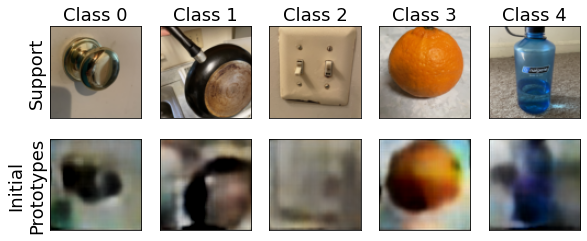

In [5]:
# Use support to compute prototypes
way = 5
shot = 1
query = 10
support_batch = iter(support_dl).next()
support_imgs, support_labels = [x.cuda() for x in support_batch]

prototypes = get_prototypes_from_data(embedding_net, support_imgs, support_labels, way=way , shot=shot)
prototypes_imgs = embedding_net.forward_decoder(prototypes.reshape(embedding_net.embedding_shape)).detach().cpu()

show_image_row([support_imgs.cpu(), prototypes_imgs.cpu()],
              ylist=['Support', 'Initial\nPrototypes'],
              tlist=[[f'Class {i}' for i in range(way)], ['']*way],
              size=(1.9,1.9),
              fontsize=18)

tensor([2, 3, 4, 2, 1, 0, 3, 4, 4, 4, 3, 2, 3, 2, 2, 0, 1, 0, 1, 0, 1, 1, 4, 1,
        4, 4, 1, 4, 3, 0, 4, 2, 2, 0, 2, 3, 0, 3, 3, 3, 0, 0, 1, 2, 2, 1, 4, 3,
        0, 1], device='cuda:0')


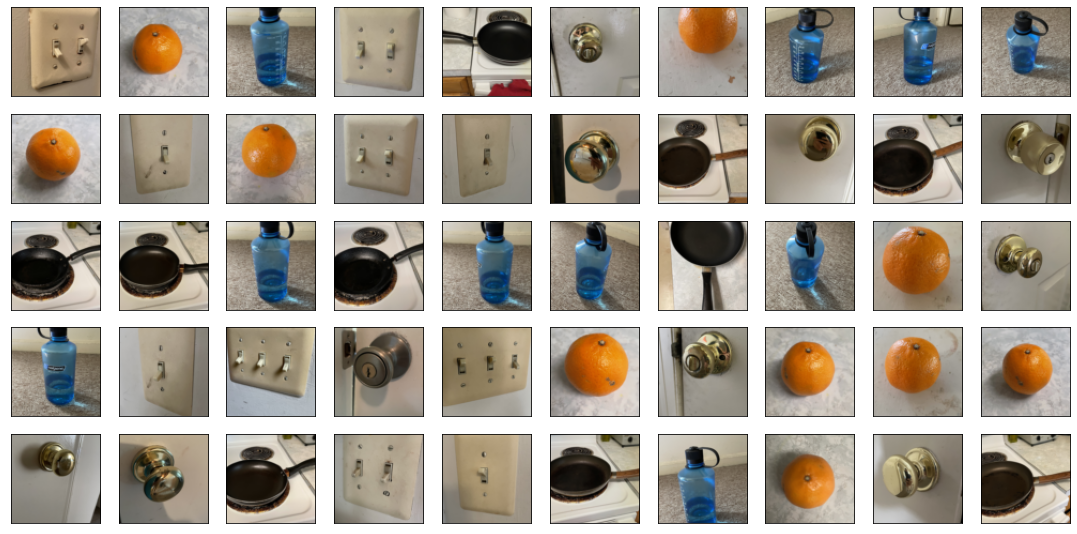

In [6]:
# Evaluate current support on query
query_batch = iter(query_dl).next()
query_imgs, query_labels = [x.cuda() for x in query_batch]
print(query_labels)
show_image_row([query_imgs[:10].cpu(), query_imgs[10:20].cpu(), query_imgs[20:30].cpu(), query_imgs[30:40].cpu(), query_imgs[40:50].cpu()], 
              size=(1.9,1.9))

In [7]:
from utils import count_accuracy

test_n_support = way * shot
test_n_query = way * query

emb_support = embedding_net(support_imgs)
emb_support = emb_support.reshape(1, test_n_support, -1)

emb_query = embedding_net(query_imgs)
emb_query = emb_query.reshape(1, test_n_query, -1)
            
logits = logits_using_prototypes(prototypes, emb_query, n_way=way, n_shot=shot)
                                 #cls_head(emb_query, emb_support, support_labels, n_way=way, n_shot=shot)
acc = count_accuracy(logits.reshape(-1, way), query_labels)
print(acc)

tensor(80.0000, device='cuda:0')


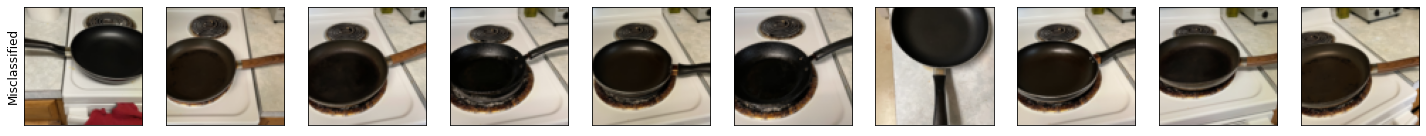

In [8]:
# Plot incorrectly classified images
tmp_logits = logits.reshape(-1, way)
pred = torch.argmax(tmp_logits, dim=1)
show_image_row([query_imgs[pred != query_labels].cpu()], ylist=['Misclassified'])

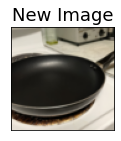

In [9]:
from PIL import Image
with Image.open("case_study_imgs/IMG_6874.jpeg") as im:
    corrected_img = transform(im)
corrected_img = corrected_img.unsqueeze(dim=0)
show_image_row([corrected_img],
              tlist = [['New Image']],
              size=(1.9,1.9),
              fontsize=18)

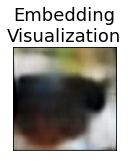

In [10]:
new_img_prototype = embedding_net(corrected_img.cuda())
new_img_prototype_img = embedding_net.forward_decoder(new_img_prototype.reshape(embedding_net.embedding_shape)).detach().cpu()
show_image_row([new_img_prototype_img],
              tlist = [['Embedding\nVisualization']],
              size=(1.9,1.9),
              fontsize=18)

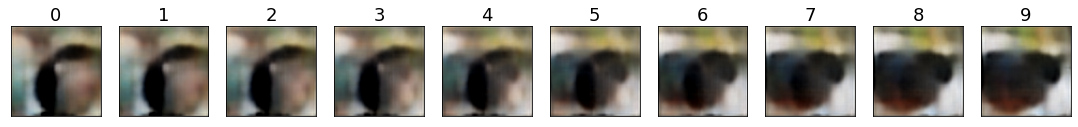

In [11]:
frying_pan_idx = 1
interpolants, interpolant_imgs = show_interpolation(embedding_net, corrected_img.cuda(), prototypes.view(way, -1)[frying_pan_idx])
show_image_row([interpolant_imgs], 
              tlist=[[f'{i}' for i in range(10)]], 
              size=(1.9,1.9),
              fontsize=18)


tensor(98.0000, device='cuda:0')


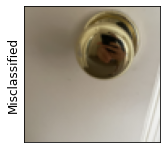

In [12]:
# Make a new prototype choice
choice_idx = 7
new_pan_prototype = interpolants[choice_idx].unsqueeze(dim=0)
prototypes[0][frying_pan_idx] = new_pan_prototype[0]
logits = logits_using_prototypes(prototypes, emb_query, n_way=way, n_shot=shot)
acc = count_accuracy(logits.reshape(-1, way), query_labels)
print(acc)

# Plot incorrectly classified images
tmp_logits = logits.reshape(-1, way)
pred = torch.argmax(tmp_logits, dim=1)
show_image_row([query_imgs[pred != query_labels].cpu()], ylist=['Misclassified'])

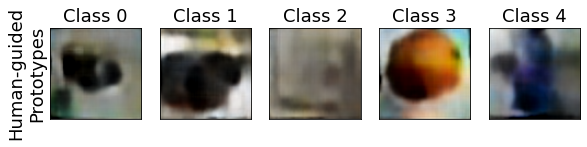

In [13]:
new_prototypes_imgs = embedding_net.forward_decoder(prototypes.reshape(embedding_net.embedding_shape)).detach().cpu()

# show_image_row([support_imgs.cpu(), prototypes_imgs.cpu(), new_prototypes_imgs.cpu()],
#               ylist=['Support', 'Initial\nPrototypes', 'Human-guided\nPrototypes'],
#               tlist=[[f'Class {i}' for i in range(way)], ['']*way, ['']*way],
#               fontsize=18)
show_image_row([new_prototypes_imgs.cpu()],
              ylist=['Human-guided\nPrototypes'],
              tlist=[[f'Class {i}' for i in range(way)], ['']*way, ['']*way],
               size=(1.9,1.9),
              fontsize=18)